# Appendix A

## Capturing Evolution of Bell State on IBM Hardware
We create a circuit using Qiskit to initialize a Bell pair. Then, we add a sequence of identity gates (a pair of Hadamard gates) to the circuit to increase the circuit depth, allowing the state to evolve over extended periods (time). Finally, we capture the output by performing state tomography to calculate the concurrence for all resulting states at different circuit depths, i.e., time intervals. <br/>
Our intial state is Bell State $\beta_{11} = (\ket{10} - \ket{01})/\sqrt(2)$.

### Imports and Saving Default Account

In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config import api_key
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.quantum_info import DensityMatrix, concurrence
from qiskit.visualization import (
    plot_bloch_multivector,
    plot_histogram,
    plot_state_qsphere,
    plot_state_city
)
from qiskit_experiments.library import StateTomography
from qiskit.compiler import transpile
from qiskit.providers.fake_provider import FakeQasmBackend, GenericBackendV2


In [2]:
## Save an IBM Quantum account as your default account, and Load saved credentials

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    instance="usc/phys550/phys550",
    token=api_key,
    set_as_default=True,
    overwrite=True,
)
service = QiskitRuntimeService()

### Quantum Circuit for Generating an Entangled Pair - Bell States $\beta_{01}$ and $\beta_{11}$
* $\beta_{01} = (\ket{01} + \ket{10})/\sqrt(2)$
* $\beta_{11} = (\ket{10} - \ket{01})/\sqrt(2)$

In [3]:
## Create quantum circuit for generating Bell state (01)

qc01 = QuantumCircuit(2)
qc01.x(1)  # Apply X gate to the second qubit
qc01.h(0)  # Apply Hadamard gate to the first qubit
qc01.cx(0, 1)  # Apply CNOT gate with the first qubit as control and the second as target
qc01.barrier()

## Quantum circuit for generating Bell state (11)

qc11 = QuantumCircuit(2)
qc11.x([0, 1])  # Apply X gate to the second qubit
qc11.h(0)  # Apply Hadamard gate to the first qubit
qc11.cx(0, 1)  # Apply CNOT gate with the first qubit as control and the second as target
qc11.barrier()

## Analyse the density matrix

density_matrix_01 = DensityMatrix.from_instruction(qc01)
density_matrix_11 = DensityMatrix.from_instruction(qc11)

Quantum circuit for preparing Bell States β₀₁ and β₁₁:


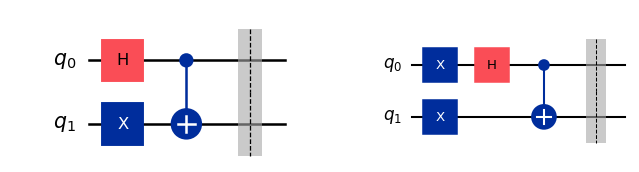

In [31]:
## Print quantum circuits

print("Quantum circuit for preparing Bell States \u03B2\u2080\u2081 and \u03B2\u2081\u2081:")
fig1, axs = plt.subplots(1, 2, figsize=(8, 4))
qc01.draw(output='mpl', ax=axs[0])
qc11.draw(output='mpl', ax=axs[1])
plt.show()

Visualization of Initial State (time = t₀):


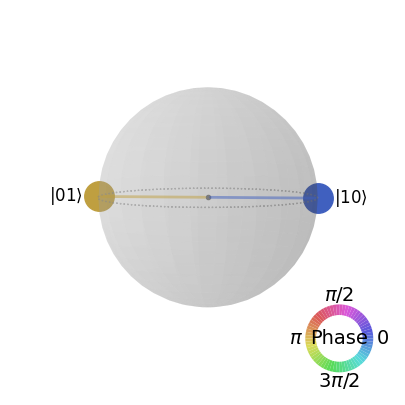

In [56]:
## Print qSpheres for Bell state (01) or (11)

print('Visualization of Initial State (time = t\u2080):')
# plot_state_qsphere(state=density_matrix_01, figsize=(5, 5))
plot_state_qsphere(state=density_matrix_11, figsize=(5, 5))

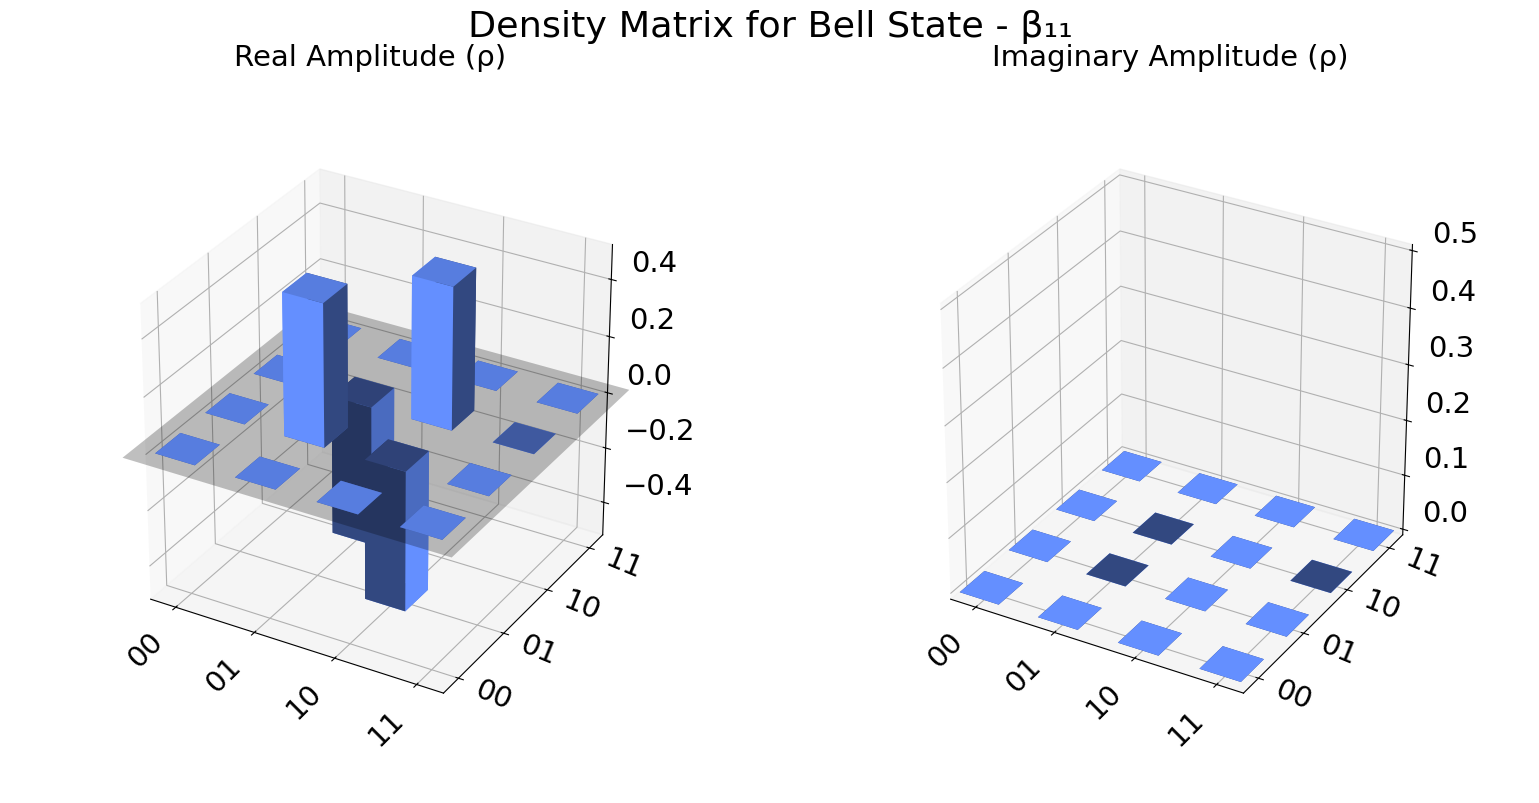

In [34]:
## Visualize Density Matrices for Bell state (01) or (11)

# plot_state_city(density_matrix_01, title='Density Matrix for Bell State - \u03B2\u2080\u2081')
plot_state_city(density_matrix_11, title='Density Matrix for Bell State - \u03B2\u2081\u2081')

### Generating $(n-1)$ Quantum Circuits for Measuring Entangled State over Time $t$
Essentially, $n = (t - t_{0})/\Delta{t}$, where $\Delta{t}$ is the time interval after which we measure the circuit again. In this experiment, we consider an arbitary $n=10$ where every $n^{th}$ circuit is created from the previous one by adding 3 sets of identity gates (using a pair of Hadamard gates) to each of the qubits.

In [7]:
from utils import list_of_circuits

n = 10
circ_list = list_of_circuits(qc11, n)

# Print out the circuits
for i in range(n):
    print(f"Circuit {i}:")
    print(circ_list[i].draw())

Circuit 0:
     ┌───┐┌───┐      ░ 
q_0: ┤ X ├┤ H ├──■───░─
     ├───┤└───┘┌─┴─┐ ░ 
q_1: ┤ X ├─────┤ X ├─░─
     └───┘     └───┘ ░ 
Circuit 1:
     ┌───┐┌───┐      ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ 
q_0: ┤ X ├┤ H ├──■───░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─
     ├───┤└───┘┌─┴─┐ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ 
q_1: ┤ X ├─────┤ X ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─
     └───┘     └───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ 
Circuit 2:
     ┌───┐┌───┐      ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ »
q_0: ┤ X ├┤ H ├──■───░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─»
     ├───┤└───┘┌─┴─┐ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ »
q_1: ┤ X ├─────┤ X ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─»
     └───┘     └───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ »
«     ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ 
«q_0: ┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─
«     ├───┤├───┤ ░ ├───┤├───┤ ░ 
«q_1: ┤ H ├┤ H ├─░─┤ H ├┤ H ├─░─
«     └───┘└───

### Running Jobs on IBM
Performing state tomography on all $n$ circuits to get the resulting density matrices.

In [8]:
service.backends()

[<IBMBackend('ibm_torino')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_sherbrooke')>]

#### State tomography on IBM Fake Backend (Noisy)

In [42]:
backend = GenericBackendV2(num_qubits=5)

noise_list = []

for i in range(n):
    qstexp = StateTomography(circ_list[i])
    qstdata = qstexp.run(backend, seed_simulation=100).block_for_results() # In StateTomography, each circuit runs 9 times
    state_result = None
    if qstdata != None:
        result = qstdata.analysis_results("state").value
    noise_list.append(
            {
                "circuit": circ_list[i],
                "tomo_result": qstdata,
                "density_matrix": result
            }
        )
    
fake_data = pd.DataFrame(noise_list)

Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'sx', 'measure', 'cx', 'x']>)) that is different than the current backend (<qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000239805BD760>). The new backend will be used, but service is not changed if one already exists.
Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'sx', 'measure', 'cx', 'x']>)) that is different than the current backend (<qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000239805BD760>). The new backend will be used, but service is not changed if one already exists.
Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'sx', 'measure', 'cx', 'x']>)) that is different than the current backend (<qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000239805BD760>). 

#### State Tomography Jobs on Real IBM Backend

In [9]:
# backend = service.backend("ibmq_qasm_simulator")
backend = service.backend("ibm_torino")

data_list = []

for i in range(n):
    qstexp = StateTomography(circ_list[i])
    qstdata = qstexp.run(backend, seed_simulation=100).block_for_results() # In StateTomography, each circuit runs 9 times
    state_result = None
    if qstdata != None:
        state_result = qstdata.analysis_results("state").value
        print(str(i)+" " + str(qstdata.experiment_id) + " : " + str(qstdata.status))
    data_list.append(
            {
                "circuit": circ_list[i],
                "tomo_result": qstdata,
                "density_matrix": state_result
            }
        )
    
data = pd.DataFrame(data_list)

c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


0 e82a1921-ef85-4e77-8aae-ae36b5d86080 : <bound method ExperimentData.status of ExperimentData(StateTomography, e82a1921-ef85-4e77-8aae-ae36b5d86080, job_ids=['crv7cx37wv80008fdpx0'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


1 4b266887-2db9-47e2-b61b-e0ff2d1c9739 : <bound method ExperimentData.status of ExperimentData(StateTomography, 4b266887-2db9-47e2-b61b-e0ff2d1c9739, job_ids=['crv9c1ry7jt000806sd0'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


2 e0aedd7a-b345-4562-a88a-d369169e8c1d : <bound method ExperimentData.status of ExperimentData(StateTomography, e0aedd7a-b345-4562-a88a-d369169e8c1d, job_ids=['crv9s6mdbt40008jtsz0'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


3 a555bd25-6dc9-4893-81d9-132f0c12b95f : <bound method ExperimentData.status of ExperimentData(StateTomography, a555bd25-6dc9-4893-81d9-132f0c12b95f, job_ids=['crva7hpx484g008f9m60'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


4 9bd88731-0dac-4147-8aef-49b11905d6c7 : <bound method ExperimentData.status of ExperimentData(StateTomography, 9bd88731-0dac-4147-8aef-49b11905d6c7, job_ids=['crvape1dbt40008jtww0'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


5 a6f8586c-0a26-4131-b077-514601ee999a : <bound method ExperimentData.status of ExperimentData(StateTomography, a6f8586c-0a26-4131-b077-514601ee999a, job_ids=['crvb4pjgd8qg008rppk0'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


6 afab8a09-deaf-4809-9bd3-e32b3f8a99cf : <bound method ExperimentData.status of ExperimentData(StateTomography, afab8a09-deaf-4809-9bd3-e32b3f8a99cf, job_ids=['crvb60gx484g008f9pvg'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


7 54a068be-b88c-48b0-846e-1a8ceefde849 : <bound method ExperimentData.status of ExperimentData(StateTomography, 54a068be-b88c-48b0-846e-1a8ceefde849, job_ids=['crvb75mdbt40008jtyf0'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


8 33a63213-8951-4ac0-86ad-450ba7922afb : <bound method ExperimentData.status of ExperimentData(StateTomography, 33a63213-8951-4ac0-86ad-450ba7922afb, job_ids=['crvb8zkdbt40008jtyng'], metadata=<4 items>)>


c:\Users\Pranavi\phys550\venv\Lib\site-packages\qiskit_experiments\framework\base_experiment.py:254: UserWarning: seed_simulation is not a recognized runtime option and may be ignored by the backend.
  jobs = experiment._run_jobs(transpiled_circuits, **run_opts)


9 2db1a4f4-1726-4cbf-a647-77af6737e738 : <bound method ExperimentData.status of ExperimentData(StateTomography, 2db1a4f4-1726-4cbf-a647-77af6737e738, job_ids=['crvbb0m7jqmg008zkw20'], metadata=<4 items>)>


In [10]:
print(data)

                                             circuit  \
0  ((Instruction(name='x', num_qubits=1, num_clbi...   
1  ((Instruction(name='x', num_qubits=1, num_clbi...   
2  ((Instruction(name='x', num_qubits=1, num_clbi...   
3  ((Instruction(name='x', num_qubits=1, num_clbi...   
4  ((Instruction(name='x', num_qubits=1, num_clbi...   
5  ((Instruction(name='x', num_qubits=1, num_clbi...   
6  ((Instruction(name='x', num_qubits=1, num_clbi...   
7  ((Instruction(name='x', num_qubits=1, num_clbi...   
8  ((Instruction(name='x', num_qubits=1, num_clbi...   
9  ((Instruction(name='x', num_qubits=1, num_clbi...   

                                         tomo_result  \
0  ----------------------------------------------...   
1  ----------------------------------------------...   
2  ----------------------------------------------...   
3  ----------------------------------------------...   
4  ----------------------------------------------...   
5  --------------------------------------------

### Compute Concurrence and Plot the Results

Concurrences from fake backend[0.9999999999999994, 0.9546849076868734, 0.9654874256262956, 0.9690013550445996, 0.9483343551473881, 0.9428245839863361, 0.9451572325374837, 0.940071253789316, 0.9281150025408194, 0.9293158747411646, 0.9301017144953896]
Concurrences from IBM hardware[0.9999999999999994, 0.6802093523826176, 0.6850437062668197, 0.6707433426077049, 0.6984040460378396, 0.6623112064563719, 0.6470150049666206, 0.6346461794987419, 0.6394879554664223, 0.6450752570544797, 0.5965711225782175]


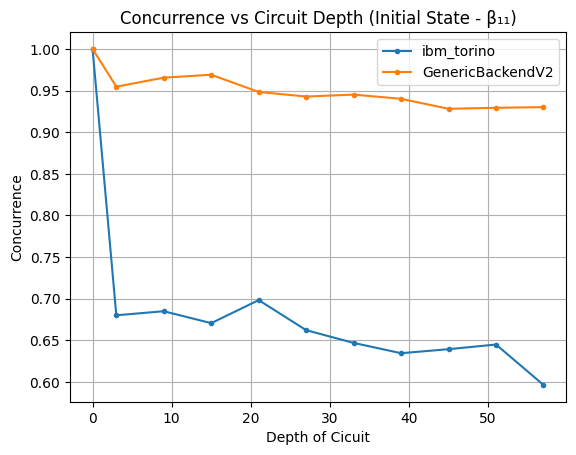

In [49]:
initial_state = density_matrix_11
fake_conc = []
conc_list = []
depths = []

## Concurrence of all states from fake noisy backend

fake_conc.append(concurrence(initial_state))
for dm in fake_data["density_matrix"]:
    fake_conc.append(concurrence(dm))
print('Concurrences from fake backend' + str(fake_conc))


## Concurrence of all resulting states from real hardware

conc_list.append(concurrence(initial_state))
for dm in data["density_matrix"]:
    conc_list.append(concurrence(dm))
print('Concurrences from IBM hardware' + str(conc_list))


## Storing circuit depths

depths.append(0) # Initializing
for circuit in data["circuit"]:
    depths.append(circuit.depth())


## Plotting Concurrence vs Circuit Depth

plt.title("Concurrence vs Circuit Depth (Initial State - \u03B2\u2081\u2081)")
plt.xlabel("Depth of Cicuit")
plt.ylabel("Concurrence")
plt.plot(depths, conc_list, marker='.', label='ibm_torino')
plt.plot(depths, fake_conc, marker='.', label='GenericBackendV2')
plt.grid(True)
plt.legend()
plt.show()

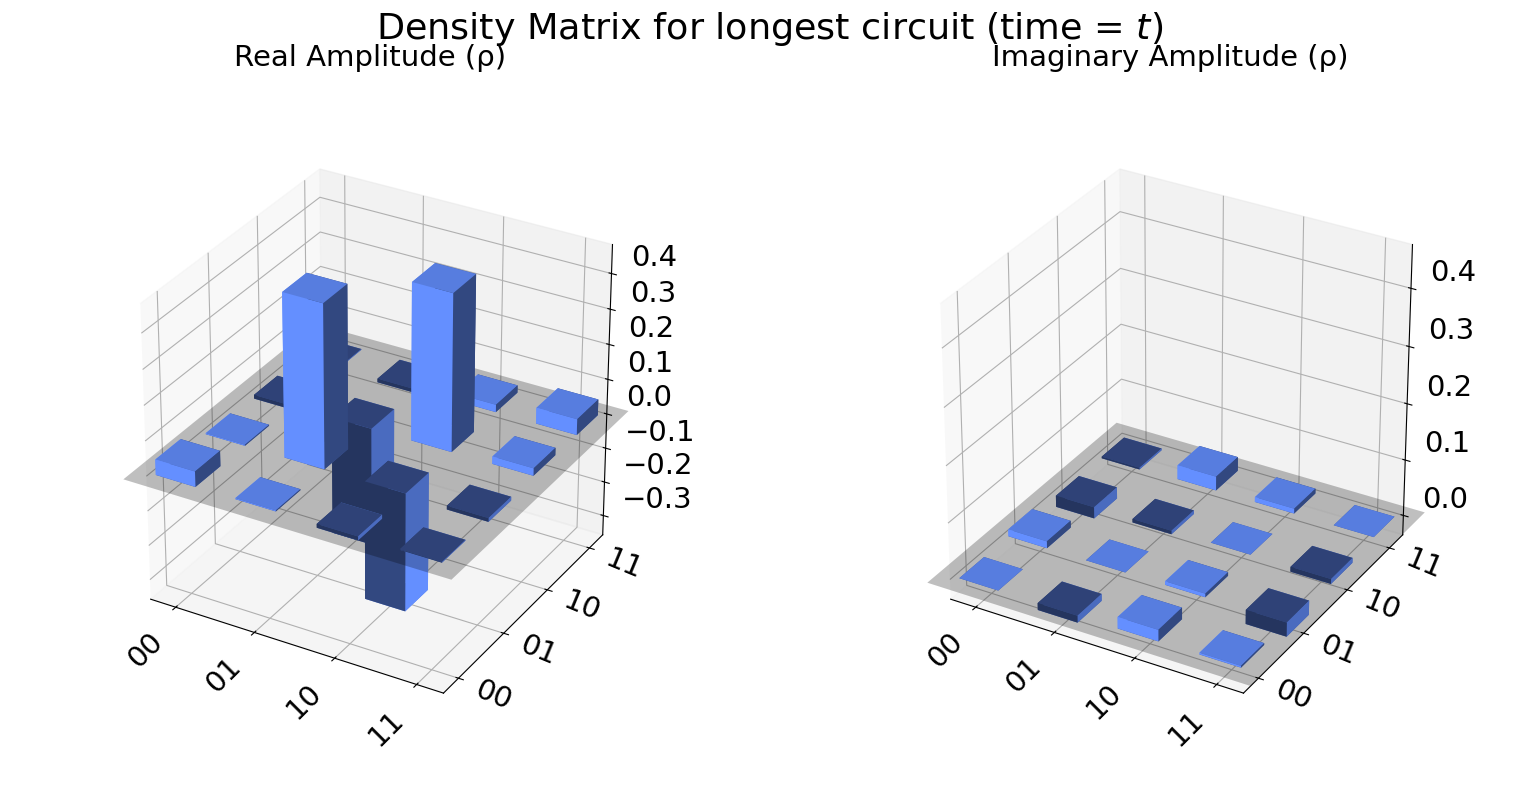

In [51]:
# Plotting the density matrix from last circuit

plot_state_city(dm, title='Density Matrix for longest circuit (time = $t$)')

Visualization of State Resulting from the Longest Circuit (time = t):


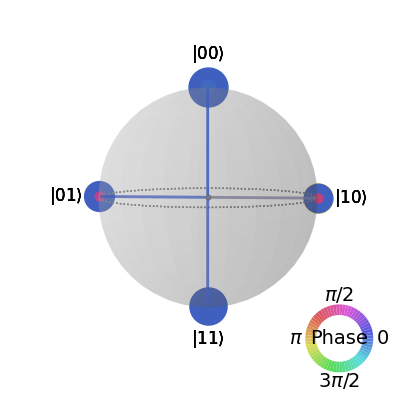

In [57]:
# Plotting the qSphere from last circuit

print('Visualization of State Resulting from the Longest Circuit (time = t):')
plot_state_qsphere(state=dm, figsize=(5, 5))

In [ ]:
# ## Check job status

# for i in range(n):
#     job = jobs[i][0]
#     print(str(job.job_id()) + ": status - "+str(job.status()))